<a href="https://colab.research.google.com/github/ayulockin/DLshots/blob/master/Kernel_Size_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setups, Imports and Installations

In [ ]:
%%capture
!pip install wandb -q

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Download Dataset and Prepare Dataloader

In [ ]:
BATCH_SIZE = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

CLASS_NAMES = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Visualize Data

In [ ]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      img = image_batch[n] / 2 + 0.5     # unnormalize
      img = img.numpy()
      plt.imshow(np.transpose(img, (1, 2, 0)))
      plt.title(CLASS_NAMES[label_batch[n]])
      plt.axis('off')

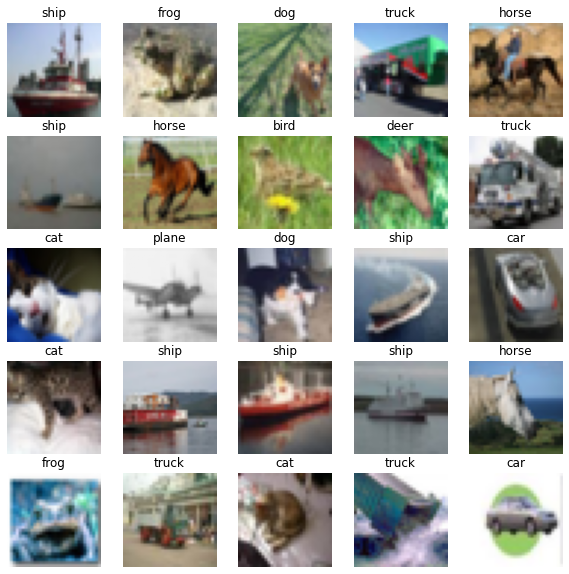

In [ ]:
sample_images, sample_labels = next(iter(trainloader))
show_batch(sample_images, sample_labels)

# Model

In [ ]:
class Net(nn.Module):
  def __init__(self, config, input_shape=(3,32,32)):
    super(Net, self).__init__()

    self.conv1 = nn.Conv2d(3, 6, config.kernel_size_one)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 32, config.kernel_size_two)

    n_size = self._get_conv_output(input_shape)

    self.fc1 = nn.Linear(n_size, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    return x

  def forward(self, x):
    x = self._forward_features(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

# Sweep Train

In [ ]:
def train():
    # Initialize wandb with a sample project name
    wandb.init()
    
    # Specify the hyperparameter to be tuned along with
    # an initial value
    configs = {
        'kernel_size_one': 3,
        'kernel_size_two': 3
    }

    # Specify the other hyperparameters to the configuration
    config = wandb.config
    config.epochs = 10

    # Add the config item (layers) to wandb
    if wandb.run:
        wandb.config.update({k: v for k, v in configs.items() if k not in dict(wandb.config.user_items())})
        configs = dict(wandb.config.user_items())

    # Iniialize model
    model = Net(wandb.config)

    # Loss
    criterion = nn.CrossEntropyLoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters())
    
    # Train the model
    for epoch in range(wandb.config.epochs):

      model.train()

      train_loss = 0
      train_total = 0
      train_correct = 0

      # We loop over the data iterator, and feed the inputs to the network and adjust the weights.
      for batch_idx, (data, target) in enumerate(trainloader, start=0):
                
        # Reset the gradients to 0 for all learnable weight parameters
        optimizer.zero_grad()
        
        # Forward pass: Pass image data from training dataset, make predictions about class image belongs to (0-9 in this case)
        output = model(data)
        
        # Define our loss function, and compute the loss
        loss = criterion(output, target)
        train_loss += loss.item()

        scores, predictions = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += int(sum(predictions == target))
                
        # Reset the gradients to 0 for all learnable weight parameters
        optimizer.zero_grad()

        # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
        loss.backward()
        
        # Update the neural network weights
        optimizer.step()

      acc = round((train_correct / train_total) * 100, 2)
      print('Epoch [{}], Loss: {}, Accuracy: {}'.format(epoch, train_loss/train_total, acc), end='')
      wandb.log({'Train Loss': train_loss/train_total, 'Train Accuracy': acc, 'Epoch': epoch})

      model.eval()

      test_loss = 0
      test_total = 0
      test_correct = 0

      example_images = []
      with torch.no_grad():
          for data, target in testloader:
              
              # Make predictions: Pass image data from test dataset, make predictions about class image belongs to (0-9 in this case)
              output = model(data)
              
              # Compute the loss sum up batch loss
              test_loss += criterion(output, target).item()
              
              scores, predictions = torch.max(output.data, 1)
              test_total += target.size(0)
              test_correct += int(sum(predictions == target))

      acc = round((test_correct / test_total) * 100, 2)
      print(' Test_loss: {}, Test_accuracy: {}'.format(test_loss/test_total, acc))
      wandb.log({'Test Loss': test_loss/test_total, 'Test Accuracy': acc})      

In [ ]:
sweep_config = {
  'method': 'bayes',
   'metric': {
     'name': 'Test Loss',
     'goal': 'minimize'  
   },
  'parameters': {
      'kernel_size_one': {
          'values': [3, 5, 7]
      },
      'kernel_size_two': {
          'values': [3, 5, 7]
      }
  }
}

In [ ]:
sweep_id = wandb.sweep(sweep_config, entity='authors', project="seo")

Create sweep with ID: et6qju5q
Sweep URL: https://app.wandb.ai/authors/seo/sweeps/et6qju5q


In [ ]:
wandb.agent(sweep_id, function=train)